In [1]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2024-03-23 16:05:20
# @Last Modified: 2024-03-23 16:05:38
# ------------------------------------------------------------------------------ #
# Here we run the bayesian analysis.
# Final plotting is done in a different notebook, as the analysis takes quite
# some time.
# ------------------------------------------------------------------------------ #

import os
import pymc as pm
import nutpie
import numpy as np
import pandas as pd
import arviz as az
import sys

import logging

logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

extra_path = os.path.abspath("../")
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph
from ana import bayesian_models as bm

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = os.path.abspath("../dat")
data_dir = os.path.abspath("/data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data")

# load our results from timescale fitting
df = pd.read_hdf(f"{data_dir}/all_units_merged_blocks_with_spont.h5", key="meta_df")

# add metrics from image selectivity etc.
df = utl.load_metrics(
    df.reset_index(),
    data_dir,
    csvs=[
        # we need to combine data from different files, because we use spontaneous and natural movie stimuli
        "brain_observatory_1.1_analysis_metrics.csv",
        "functional_connectivity_analysis_metrics.csv",
    ],
    cols=["on_screen_rf"],
)
df = utl.add_structure_and_hierarchy_scores(df)
df = utl.load_experiments(df, data_dir)

# pymc does not like bools:
log.info(f'invalid metric rows: {df["on_screen_rf"].isna().sum()}')
df["on_screen_rf"] = df["on_screen_rf"].astype("int")

len_before = len(df)
df = df.query("tau_R > 0.0")
df = df.query("tau_double > 0.0 & tau_double < 10.0")
# timescales above 10s are likely an inference problems,
# as we have 600 - 800 seconds of data. cf. https://arxiv.org/abs/2007.03367
len_after = len(df)
log.info(f"removed {len_before - len_after} rows due to unexpected timescales")

# select only cortical units 
df = df.query("structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']") 


# some further preprocessing is done in the model class
# see ana/bayesian_models.py
df


2024-05-21 14:35:10,074 | INFO     | notebook | <module> | project directory: /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code_repo/experiment_analysis
2024-05-21 14:35:24,028 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'on_screen_rf'] from /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_1.1_analysis_metrics.csv
2024-05-21 14:35:24,537 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'on_screen_rf'] from /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/functional_connectivity_analysis_metrics.csv
2024-05-21 14:35:24,538 | INFO     | its_utility | load_metrics | Column on_screen_rf found in multiple dataframes.
2024-05-21 14:35:24,540 | DEBUG    | its_utility | load_metrics | Matched 6368 rows from meta_df in /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_anal

,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,on_screen_rf,structure_name,hierarchy_score,session_type
0,950911932,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,8655,...,0.058510,0.000054,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0,AM,0.441,brain_observatory_1.1
1,950911986,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,3936,...,0.088701,2.302634,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0,AM,0.441,brain_observatory_1.1
2,950912164,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,9162,...,0.059416,1.026283,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",1,AM,0.441,brain_observatory_1.1
3,950912190,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,4730,...,0.116100,1.564297,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",1,AM,0.441,brain_observatory_1.1
4,950912214,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,5718,...,0.064748,0.605686,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",1,AM,0.441,brain_observatory_1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17944,950942400,spontaneous,771160300,null,VISal,SUCCESS,1797.115234,0.377828,/project.nst/neuroscience-raw/Allen/visual_cod...,679,...,0.049446,0.257024,0.217925,"{'firing_rate': 0.36583331347267567, 'firing_r...","{'tau': 0.25702383931940154, 'mre': 0.98073454...","{'tau': 0.2179251442600049, 'mre': 0.977317546...",0,AL,0.152,functional_connectivity
17945,950944614,spontaneous,771160300,null,VISal,SUCCESS,1792.901855,0.377600,/project.nst/neuroscience-raw/Allen/visual_cod...,677,...,0.042486,0.439570,0.057439,"{'firing_rate': 0.38629086027452963, 'firing_r...","{'tau': 0.4395698459887982, 'mre': 0.988689691...","{'tau': 0.05743850656844875, 'mre': 0.91663161...",0,AL,0.152,functional_connectivity
17946,950943984,spontaneous,771160300,null,VISal,SUCCESS,1773.977051,0.135289,/project.nst/neuroscience-raw/Allen/visual_cod...,240,...,0.043392,0.170987,0.170986,"{'firing_rate': 0.13628681470096451, 'firing_r...","{'tau': 0.1709865057191234, 'mre': 0.971181338...","{'tau': 0.17098641292634262, 'mre': 0.97118132...",0,AL,0.152,functional_connectivity
17947,950942680,spontaneous,771160300,null,VISal,SUCCESS,1801.591797,12.195324,/project.nst/neuroscience-raw/Allen/visual_cod...,21971,...,0.008184,0.081918,0.068260,"{'firing_rate': 12.154834329411557, 'firing_ra...","{'tau': 0.08191797577480081, 'mre': 0.94078874...","{'tau': 0.06826005692776223, 'mre': 0.92936912...",1,AL,0.152,functional_connectivity


In [2]:
np.unique(df.ecephys_structure_acronym.values)

array(['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl'], dtype=object)

         mu_intercept ~ Normal(0, 1)
      sigma_intercept ~ HalfCauchy(0, 1)
             mu_slope ~ Normal(0, 1)
          sigma_slope ~ HalfCauchy(0, 1)
    session_intercept ~ Normal(0, 1)
        session_slope ~ Normal(0, 1)
              b_os_rf ~ Normal(0, 1)
             b_log_fr ~ Normal(0, 1)
              epsilon ~ HalfCauchy(0, 10)
    eff_session_slope ~ Deterministic(f(session_slope, mu_slope, sigma_slope))
eff_session_intercept ~ Deterministic(f(session_intercept, mu_intercept, sigma_intercept))
           linear_fit ~ Deterministic(f(mu_intercept, mu_slope))
           likelihood ~ Normal(f(b_log_fr, b_os_rf, mu_intercept, mu_slope, session_intercept, sigma_intercept, session_slope, sigma_slope), epsilon)


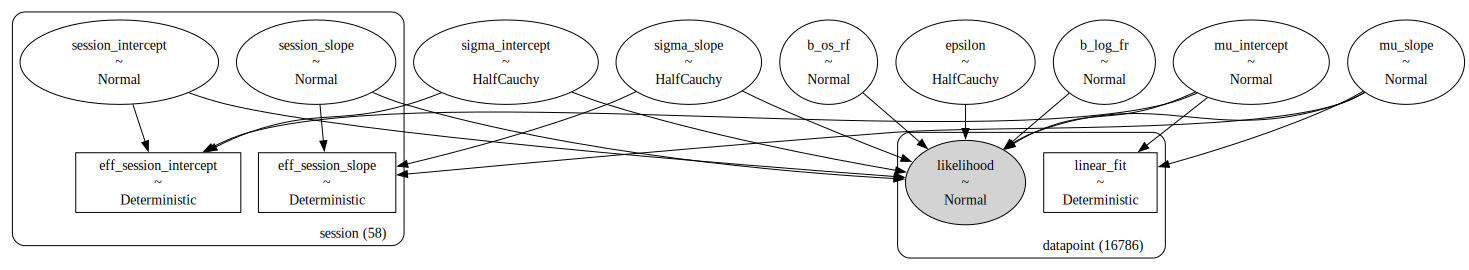

In [2]:
lm_R_tot = bm.LinearModel(df, "R_tot")
print(lm_R_tot.str_repr())
pm.model_to_graphviz(lm_R_tot)

         mu_intercept ~ Normal(0, 1)
      sigma_intercept ~ HalfCauchy(0, 0.1)
         mu_hc_offset ~ Normal(0, 1)
      sigma_hc_offset ~ HalfCauchy(0, 1)
         mu_th_offset ~ Normal(0, 1)
      sigma_th_offset ~ HalfCauchy(0, 1)
    session_intercept ~ Normal(0, 1)
    session_hc_offset ~ Normal(0, 1)
    session_th_offset ~ Normal(0, 1)
              b_os_rf ~ Normal(0, 1)
             b_log_fr ~ Normal(0, 1)
              epsilon ~ HalfCauchy(0, 10)
eff_session_hc_offset ~ Deterministic(f(session_hc_offset, mu_hc_offset, sigma_hc_offset))
eff_session_th_offset ~ Deterministic(f(session_th_offset, mu_th_offset, sigma_th_offset))
eff_session_intercept ~ Deterministic(f(session_intercept, mu_intercept, sigma_intercept))
           likelihood ~ Normal(f(b_log_fr, b_os_rf, mu_th_offset, mu_intercept, sigma_th_offset, session_th_offset, mu_hc_offset, session_intercept, sigma_intercept, sigma_hc_offset, session_hc_offset), epsilon)


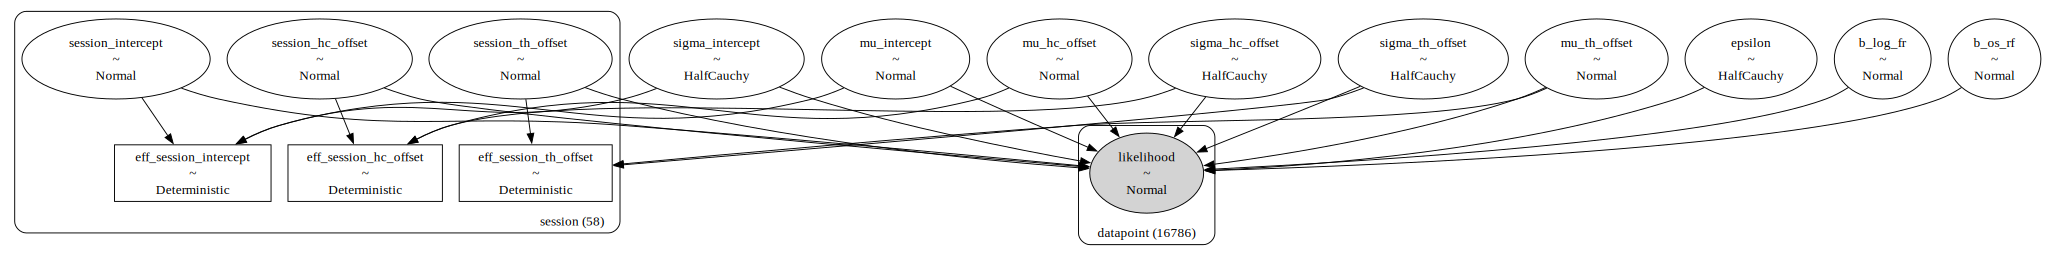

In [3]:
sgm_R_tot = bm.StructureGroupModel(df, "R_tot")
print(sgm_R_tot.str_repr())
pm.model_to_graphviz(sgm_R_tot)

# Example analysis for linear model and measure `R_tot`

In [10]:
lm_R_tot = bm.LinearModel(
    df.query("stimulus == 'natural_movie_one_more_repeats'"), "R_tot"
)
with lm_R_tot:
    idata_lm = pm.sample(
        nuts_sampler="nutpie",
        draws=3000,
        tune=2000,
        random_seed=42,
        target_accept=0.95,
    )

In [9]:
sgm_R_tot = bm.StructureGroupModel(
    df.query("stimulus == 'natural_movie_one_more_repeats'"), "R_tot"
)
with sgm_R_tot:
    idata_sgm = pm.sample(
        nuts_sampler="nutpie",
        draws=3000,
        tune=2000,
        random_seed=42,
        target_accept=0.95,
    )

In [4]:
with lm_R_tot:
    idata.extend(pm.sample_prior_predictive(random_seed=42))
    idata.extend(pm.sample_posterior_predictive(trace=idata, random_seed=42))

Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
2024-05-21 14:37:06,478 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
Sampling: [likelihood]
2024-05-21 14:37:06,977 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

In [18]:
# with lm_R_tot:
#     idata_lm.extend(pm.compute_log_likelihood(idata_lm))
loo_lm = az.loo(idata_lm, pointwise=True)
# with sgm_R_tot:
#     idata_sgm.extend(pm.compute_log_likelihood(idata_sgm))
loo_sgm = az.loo(idata_sgm, pointwise=True)
print(loo_lm, loo_sgm)

Computed from 12000 posterior samples and 4554 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6185.44    61.44
p_loo       32.34        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     4554  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%
 Computed from 12000 posterior samples and 4554 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6185.44    61.44
p_loo       32.34        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     4554  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [7]:
az.summary(
    idata,
    var_names=[
        "b_log_fr",
        "b_os_rf",
        "epsilon",
        "mu_intercept",
        "mu_slope",
        "sigma_intercept",
        "sigma_slope",
        "session_slope",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_log_fr,-0.624,0.026,-0.673,-0.576,0.000,0.000,24618.0,8372.0,1.0
b_os_rf,0.092,0.026,0.043,0.142,0.000,0.000,21494.0,9625.0,1.0
epsilon,0.937,0.009,0.920,0.954,0.000,0.000,26452.0,7090.0,1.0
mu_intercept,0.028,0.042,-0.054,0.106,0.001,0.000,6290.0,7794.0,1.0
mu_slope,-0.064,0.035,-0.132,-0.001,0.000,0.000,8161.0,8120.0,1.0
sigma_intercept,0.139,0.033,0.080,0.201,0.000,0.000,4970.0,6518.0,1.0
sigma_slope,0.103,0.031,0.046,0.164,0.001,0.000,3779.0,2710.0,1.0
session_slope[0],0.122,0.724,-1.249,1.493,0.006,0.006,16825.0,10182.0,1.0
session_slope[1],-1.231,0.746,-2.631,0.170,0.007,0.005,13590.0,8434.0,1.0
session_slope[2],0.871,0.756,-0.554,2.295,0.006,0.005,17069.0,8555.0,1.0


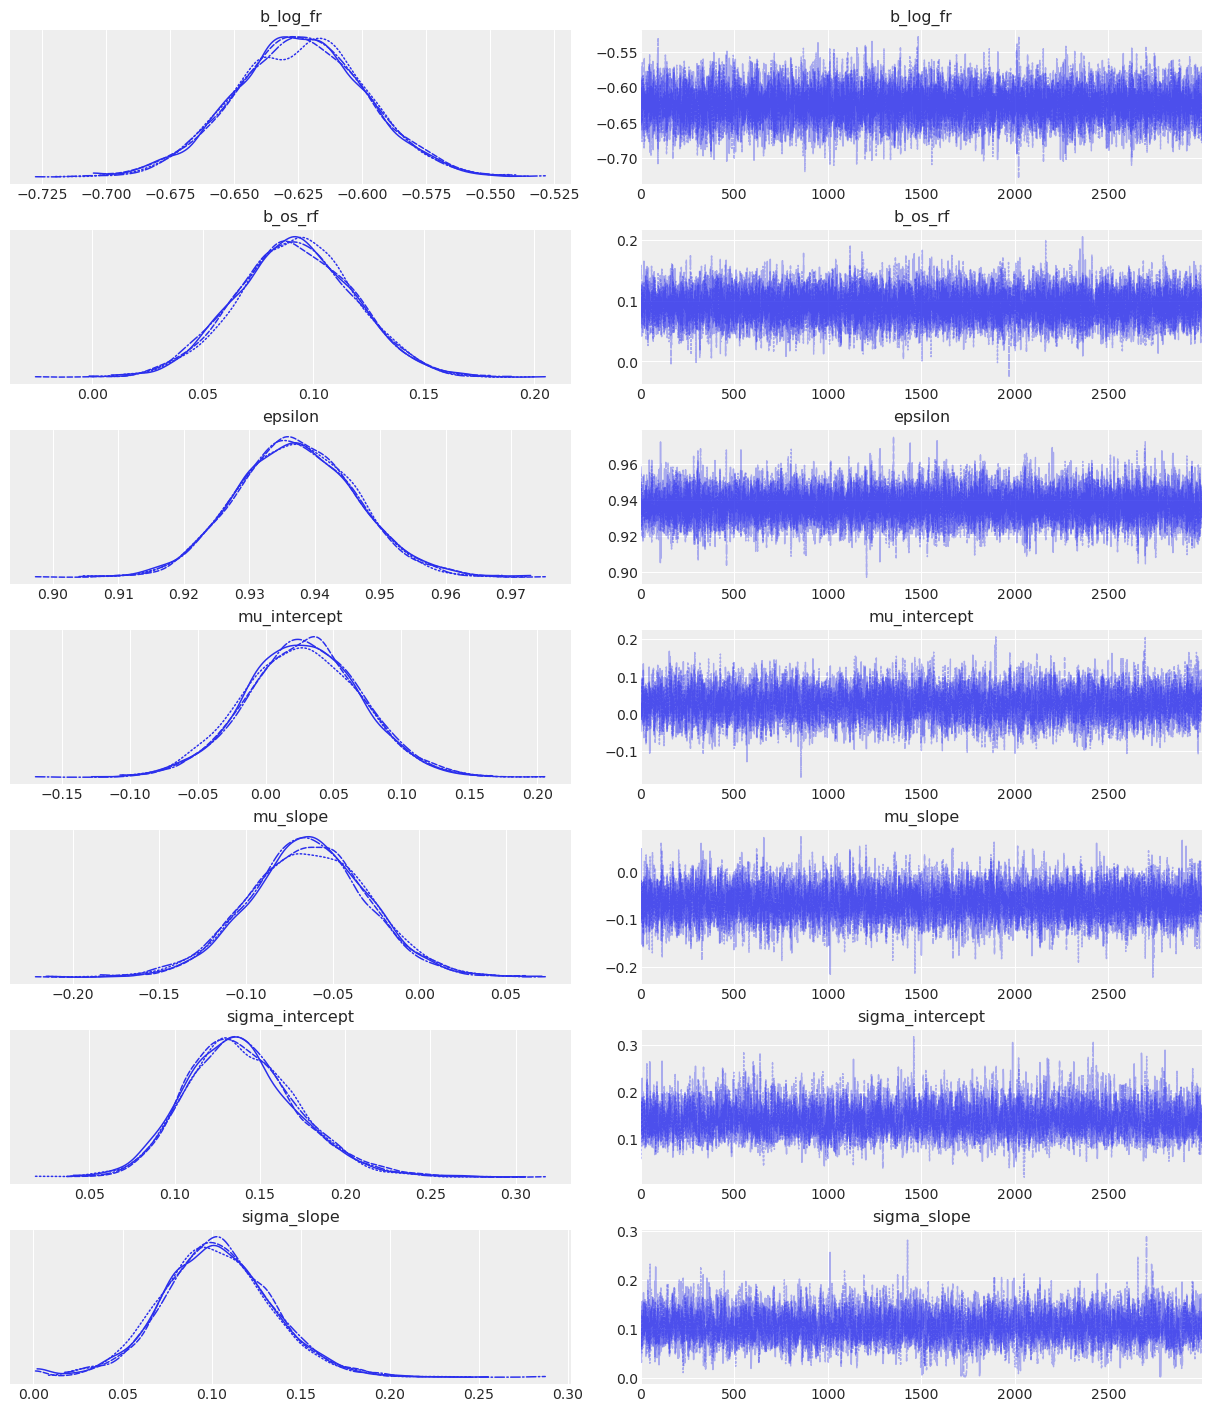

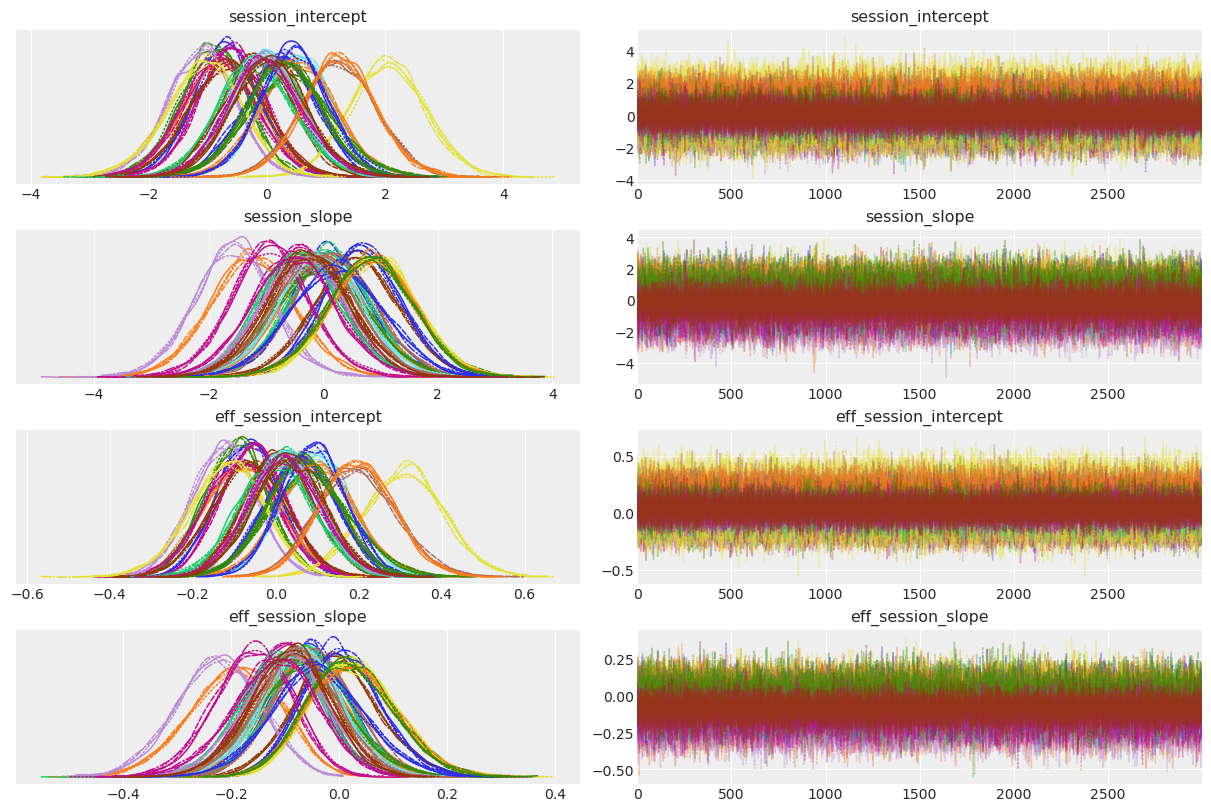

In [8]:
az.style.use("arviz-darkgrid")
# blue lines represent chains
az.plot_trace(
    idata,
    var_names=[
        "b_log_fr",
        "b_os_rf",
        "epsilon",
        "mu_intercept",
        "mu_slope",
        "sigma_intercept",
        "sigma_slope",
    ],
    legend=False,
);
# color varies across sessions
az.plot_trace(
    idata,
    var_names=[
        "session_intercept",
        "session_slope",
        "eff_session_intercept",
        "eff_session_slope",
    ],
    legend=False,
);

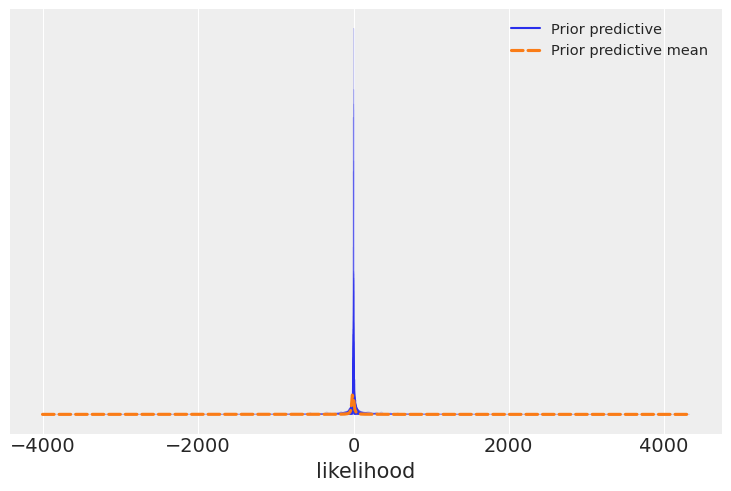

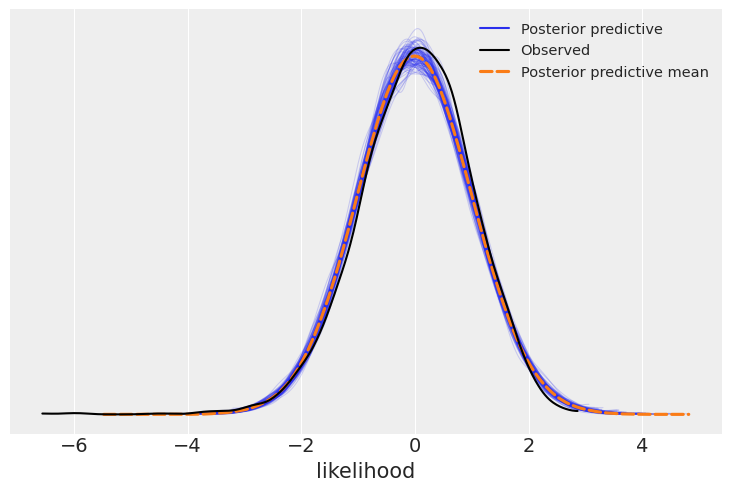

In [9]:
az.plot_ppc(
    idata,
    num_pp_samples=100,
    kind="kde",
    group="prior",
);
az.plot_ppc(
    idata,
    num_pp_samples=100,
    kind="kde",
    group="posterior",
);

# Generate traces for model comparison

In [10]:
from itertools import product


# define models
models = ["lm", "sgm"]
stimuli = df["stimulus"].unique()
measures = ["R_tot", "tau_R", "tau_double"]
combinations = list(product(models, stimuli, measures))
log.info(f"{combinations=}")

# ~1h on M1 mac
for model_name, stim, measure in combinations:
    log.info(f"running: {model_name} {stim} {measure}")

    this_df = df.query(f"stimulus == '{stim}'")
    log.info(f"using df for {stim} with {len(this_df)} rows")
    if model_name == "lm":
        model = bm.LinearModel(this_df, measure)
    else:
        model = bm.StructureGroupModel(this_df, measure)

    with model:
        idata = pm.sample(
            nuts_sampler="nutpie",
            draws=3000,
            tune=2000,
            random_seed=42,
            target_accept=0.95,
        )

        log.info(f"running ppc: {model_name}")
        idata.extend(pm.sample_prior_predictive(random_seed=42))
        idata.extend(pm.sample_posterior_predictive(trace=idata, random_seed=42))

        log.info(f"computing likeliehood: {model_name}")
        idata.extend(pm.compute_log_likelihood(idata))

        log.info(f"saving: {model_name}")
        idata.to_netcdf(f"{data_dir}/bayes_{model_name}_{measure}_{stim}.nc") # ~ 1.8GB each


2024-05-21 11:49:22,030 | INFO     | notebook | <module> | combinations=[('lm', 'natural_movie_three', 'R_tot'), ('lm', 'natural_movie_three', 'tau_R'), ('lm', 'natural_movie_three', 'tau_double'), ('lm', 'natural_movie_one_more_repeats', 'R_tot'), ('lm', 'natural_movie_one_more_repeats', 'tau_R'), ('lm', 'natural_movie_one_more_repeats', 'tau_double'), ('lm', 'spontaneous', 'R_tot'), ('lm', 'spontaneous', 'tau_R'), ('lm', 'spontaneous', 'tau_double'), ('sgm', 'natural_movie_three', 'R_tot'), ('sgm', 'natural_movie_three', 'tau_R'), ('sgm', 'natural_movie_three', 'tau_double'), ('sgm', 'natural_movie_one_more_repeats', 'R_tot'), ('sgm', 'natural_movie_one_more_repeats', 'tau_R'), ('sgm', 'natural_movie_one_more_repeats', 'tau_double'), ('sgm', 'spontaneous', 'R_tot'), ('sgm', 'spontaneous', 'tau_R'), ('sgm', 'spontaneous', 'tau_double')]
2024-05-21 11:49:22,031 | INFO     | notebook | <module> | running: lm natural_movie_three R_tot
2024-05-21 11:49:22,037 | INFO     | notebook | <modu

2024-05-21 11:50:16,374 | INFO     | notebook | <module> | running ppc: lm
Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
2024-05-21 11:50:24,132 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
Sampling: [likelihood]
2024-05-21 11:50:24,595 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 11:50:27,329 | INFO     | notebook | <module> | computing likeliehood: lm


Output()

2024-05-21 11:50:30,977 | INFO     | notebook | <module> | saving: lm
2024-05-21 11:51:40,719 | INFO     | notebook | <module> | running: lm natural_movie_three tau_R
2024-05-21 11:51:40,724 | INFO     | notebook | <module> | using df for natural_movie_three with 6076 rows


2024-05-21 11:53:36,762 | INFO     | notebook | <module> | running ppc: lm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
2024-05-21 11:53:38,133 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
Sampling: [likelihood]
2024-05-21 11:53:38,625 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 11:53:43,356 | INFO     | notebook | <module> | computing likeliehood: lm


Output()

2024-05-21 11:53:48,398 | INFO     | notebook | <module> | saving: lm
2024-05-21 11:54:34,528 | INFO     | notebook | <module> | running: lm natural_movie_three tau_double
2024-05-21 11:54:34,533 | INFO     | notebook | <module> | using df for natural_movie_three with 6076 rows


2024-05-21 11:56:43,628 | INFO     | notebook | <module> | running ppc: lm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
2024-05-21 11:56:44,429 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
Sampling: [likelihood]
2024-05-21 11:56:44,958 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 11:56:50,014 | INFO     | notebook | <module> | computing likeliehood: lm


Output()

2024-05-21 11:56:54,747 | INFO     | notebook | <module> | saving: lm
2024-05-21 11:57:46,070 | INFO     | notebook | <module> | running: lm natural_movie_one_more_repeats R_tot
2024-05-21 11:57:46,079 | INFO     | notebook | <module> | using df for natural_movie_one_more_repeats with 5312 rows


2024-05-21 11:58:15,328 | INFO     | notebook | <module> | running ppc: lm
Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
2024-05-21 11:58:17,267 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
Sampling: [likelihood]
2024-05-21 11:58:17,682 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 11:58:20,101 | INFO     | notebook | <module> | computing likeliehood: lm


Output()

2024-05-21 11:58:21,370 | INFO     | notebook | <module> | saving: lm
2024-05-21 11:59:05,229 | INFO     | notebook | <module> | running: lm natural_movie_one_more_repeats tau_R
2024-05-21 11:59:05,240 | INFO     | notebook | <module> | using df for natural_movie_one_more_repeats with 5312 rows


2024-05-21 12:01:00,509 | INFO     | notebook | <module> | running ppc: lm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
2024-05-21 12:01:01,287 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
Sampling: [likelihood]
2024-05-21 12:01:01,768 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 12:01:06,428 | INFO     | notebook | <module> | computing likeliehood: lm


Output()

2024-05-21 12:01:10,738 | INFO     | notebook | <module> | saving: lm
2024-05-21 12:01:49,784 | INFO     | notebook | <module> | running: lm natural_movie_one_more_repeats tau_double
2024-05-21 12:01:49,789 | INFO     | notebook | <module> | using df for natural_movie_one_more_repeats with 5312 rows


2024-05-21 12:04:12,352 | INFO     | notebook | <module> | running ppc: lm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
2024-05-21 12:04:13,150 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
Sampling: [likelihood]
2024-05-21 12:04:13,621 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 12:04:18,363 | INFO     | notebook | <module> | computing likeliehood: lm


Output()

2024-05-21 12:04:22,484 | INFO     | notebook | <module> | saving: lm
2024-05-21 12:05:00,544 | INFO     | notebook | <module> | running: lm spontaneous R_tot
2024-05-21 12:05:00,549 | INFO     | notebook | <module> | using df for spontaneous with 5398 rows


2024-05-21 12:05:29,162 | INFO     | notebook | <module> | running ppc: lm
Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
2024-05-21 12:05:30,898 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
Sampling: [likelihood]
2024-05-21 12:05:31,312 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 12:05:33,953 | INFO     | notebook | <module> | computing likeliehood: lm


Output()

2024-05-21 12:05:35,296 | INFO     | notebook | <module> | saving: lm
2024-05-21 12:06:16,287 | INFO     | notebook | <module> | running: lm spontaneous tau_R
2024-05-21 12:06:16,291 | INFO     | notebook | <module> | using df for spontaneous with 5398 rows


2024-05-21 12:08:30,118 | INFO     | notebook | <module> | running ppc: lm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
2024-05-21 12:08:31,413 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
Sampling: [likelihood]
2024-05-21 12:08:31,917 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 12:08:36,762 | INFO     | notebook | <module> | computing likeliehood: lm


Output()

2024-05-21 12:08:41,473 | INFO     | notebook | <module> | saving: lm
2024-05-21 12:09:22,286 | INFO     | notebook | <module> | running: lm spontaneous tau_double
2024-05-21 12:09:22,290 | INFO     | notebook | <module> | using df for spontaneous with 5398 rows


2024-05-21 12:11:52,884 | INFO     | notebook | <module> | running ppc: lm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
2024-05-21 12:11:53,639 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_intercept, mu_slope, session_intercept, session_slope, sigma_intercept, sigma_slope]
Sampling: [likelihood]
2024-05-21 12:11:54,136 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 12:11:58,787 | INFO     | notebook | <module> | computing likeliehood: lm


Output()

2024-05-21 12:12:03,148 | INFO     | notebook | <module> | saving: lm
2024-05-21 12:12:50,504 | INFO     | notebook | <module> | running: sgm natural_movie_three R_tot
2024-05-21 12:12:50,520 | INFO     | notebook | <module> | using df for natural_movie_three with 6076 rows


2024-05-21 12:13:34,680 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2024-05-21 12:13:34,873 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2024-05-21 12:13:35,252 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 12:13:38,128 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2024-05-21 12:13:39,955 | INFO     | notebook | <module> | saving: sgm
2024-05-21 12:14:24,673 | INFO     | notebook | <module> | running: sgm natural_movie_three tau_R
2024-05-21 12:14:24,690 | INFO     | notebook | <module> | using df for natural_movie_three with 6076 rows


2024-05-21 12:16:29,720 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2024-05-21 12:16:29,815 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2024-05-21 12:16:30,279 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 12:16:35,561 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2024-05-21 12:16:40,510 | INFO     | notebook | <module> | saving: sgm
2024-05-21 12:17:23,033 | INFO     | notebook | <module> | running: sgm natural_movie_three tau_double
2024-05-21 12:17:23,036 | INFO     | notebook | <module> | using df for natural_movie_three with 6076 rows


2024-05-21 12:19:54,397 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2024-05-21 12:19:55,485 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2024-05-21 12:19:55,968 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 12:20:01,319 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2024-05-21 12:20:06,930 | INFO     | notebook | <module> | saving: sgm
2024-05-21 12:20:47,452 | INFO     | notebook | <module> | running: sgm natural_movie_one_more_repeats R_tot
2024-05-21 12:20:47,457 | INFO     | notebook | <module> | using df for natural_movie_one_more_repeats with 5312 rows


2024-05-21 12:21:33,230 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2024-05-21 12:21:33,344 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2024-05-21 12:21:33,709 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 12:21:36,417 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2024-05-21 12:21:38,021 | INFO     | notebook | <module> | saving: sgm
2024-05-21 12:22:16,239 | INFO     | notebook | <module> | running: sgm natural_movie_one_more_repeats tau_R
2024-05-21 12:22:16,243 | INFO     | notebook | <module> | using df for natural_movie_one_more_repeats with 5312 rows


2024-05-21 12:24:41,760 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2024-05-21 12:24:41,878 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2024-05-21 12:24:42,342 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 12:24:47,205 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2024-05-21 12:24:51,599 | INFO     | notebook | <module> | saving: sgm
2024-05-21 12:25:34,529 | INFO     | notebook | <module> | running: sgm natural_movie_one_more_repeats tau_double
2024-05-21 12:25:34,545 | INFO     | notebook | <module> | using df for natural_movie_one_more_repeats with 5312 rows


2024-05-21 12:27:59,453 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2024-05-21 12:27:59,545 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2024-05-21 12:27:59,979 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 12:28:04,772 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2024-05-21 12:28:09,105 | INFO     | notebook | <module> | saving: sgm
2024-05-21 12:28:47,851 | INFO     | notebook | <module> | running: sgm spontaneous R_tot
2024-05-21 12:28:47,855 | INFO     | notebook | <module> | using df for spontaneous with 5398 rows


2024-05-21 12:29:30,091 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2024-05-21 12:29:30,189 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2024-05-21 12:29:30,554 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 12:29:33,350 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2024-05-21 12:29:35,631 | INFO     | notebook | <module> | saving: sgm
2024-05-21 12:30:13,128 | INFO     | notebook | <module> | running: sgm spontaneous tau_R
2024-05-21 12:30:13,132 | INFO     | notebook | <module> | using df for spontaneous with 5398 rows


2024-05-21 12:32:58,413 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2024-05-21 12:32:58,507 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2024-05-21 12:32:58,968 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 12:33:03,869 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2024-05-21 12:33:08,843 | INFO     | notebook | <module> | saving: sgm
2024-05-21 12:33:48,426 | INFO     | notebook | <module> | running: sgm spontaneous tau_double
2024-05-21 12:33:48,430 | INFO     | notebook | <module> | using df for spontaneous with 5398 rows


2024-05-21 12:36:52,563 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2024-05-21 12:36:52,669 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset, session_intercept, session_th_offset, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2024-05-21 12:36:53,116 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2024-05-21 12:36:58,147 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2024-05-21 12:37:04,240 | INFO     | notebook | <module> | saving: sgm


# Reviewer Suggestion

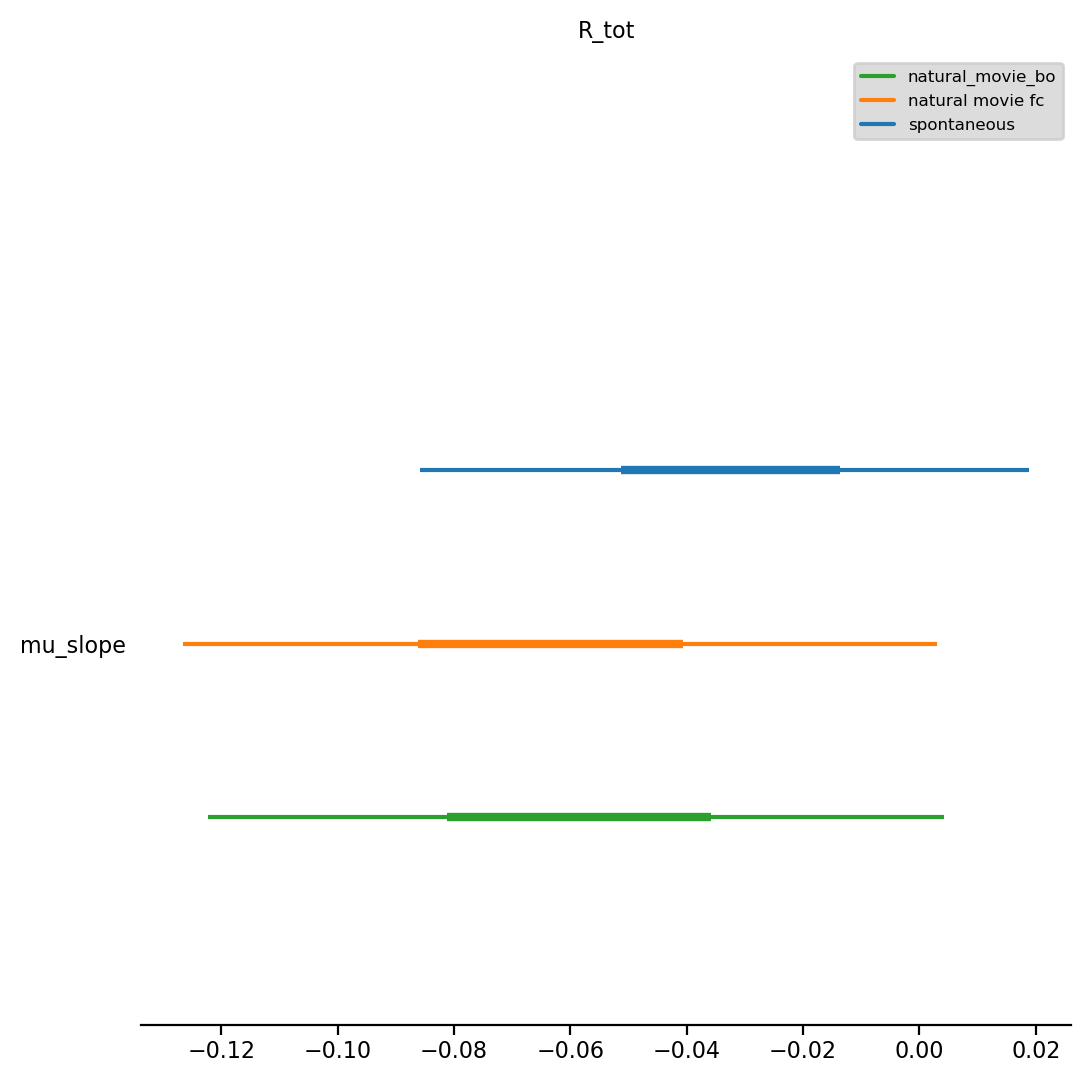

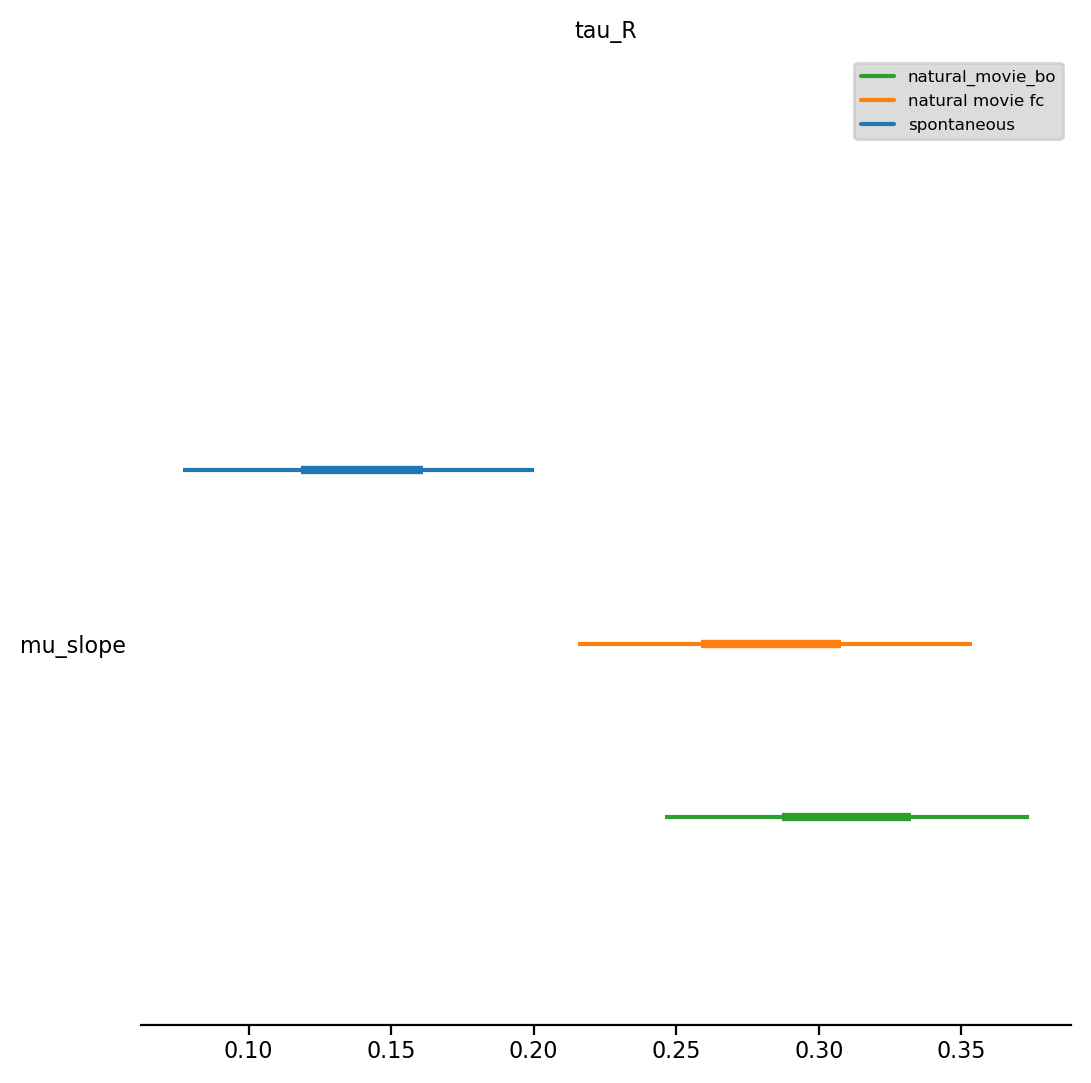

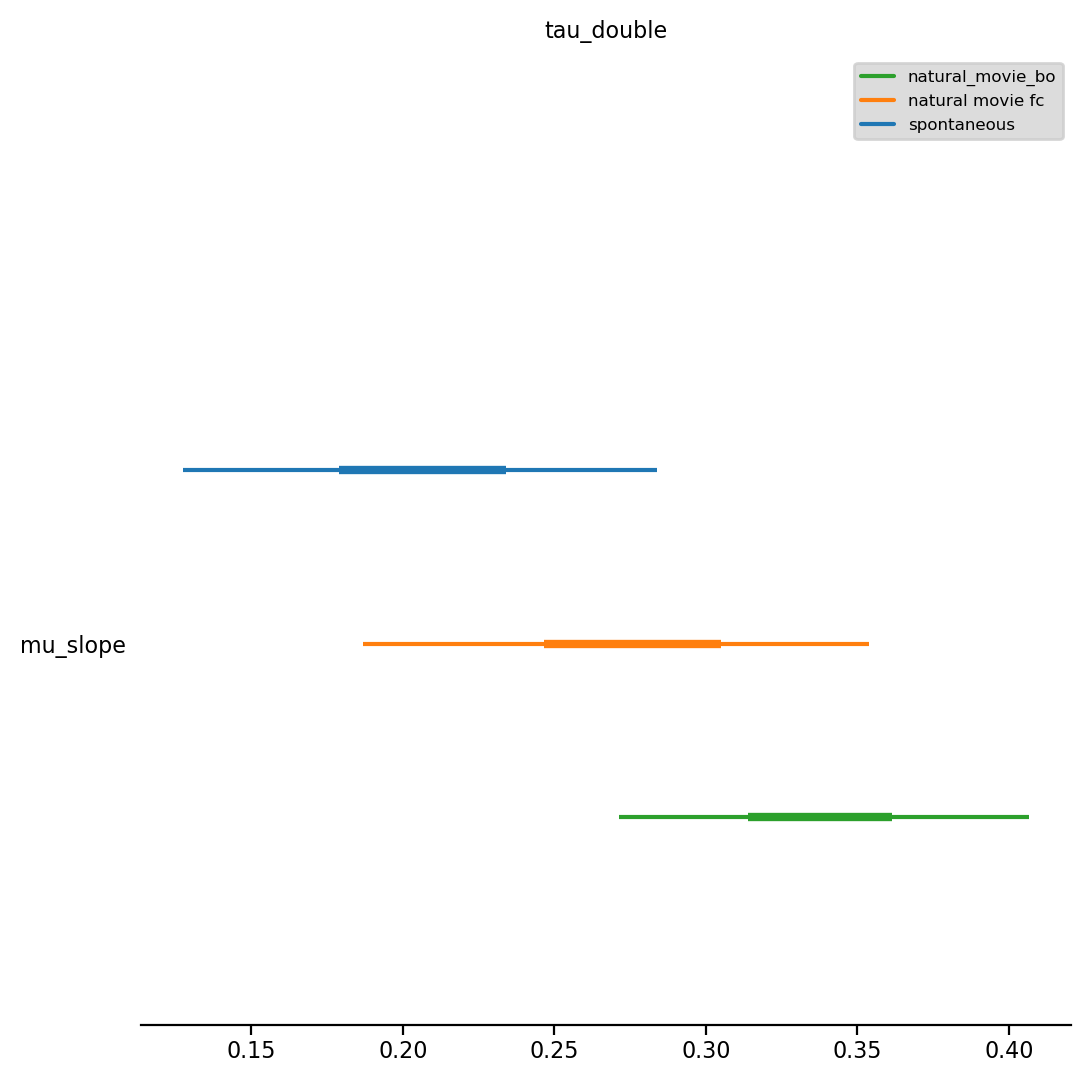

In [11]:
for obs in ["R_tot", "tau_R", "tau_double"]:
    idata_spont = az.from_netcdf(f"{data_dir}/bayes_lm_{obs}_spontaneous.nc")
    idata_nat_mov_fc = az.from_netcdf(f"{data_dir}/bayes_lm_{obs}_natural_movie_one_more_repeats.nc")
    idata_nat_mov_bo = az.from_netcdf(f"{data_dir}/bayes_lm_{obs}_natural_movie_three.nc")
    ax = az.plot_forest(
        [
            idata_spont,
            idata_nat_mov_fc,
            idata_nat_mov_bo,
        ],
        model_names=["spontaneous", "natural movie fc", "natural_movie_bo"],
        var_names=["mu_slope"],
        combined=True, # combines chains
        combine_dims=set(["draw", "session"]),
    )
    ax[0].set_title(obs)

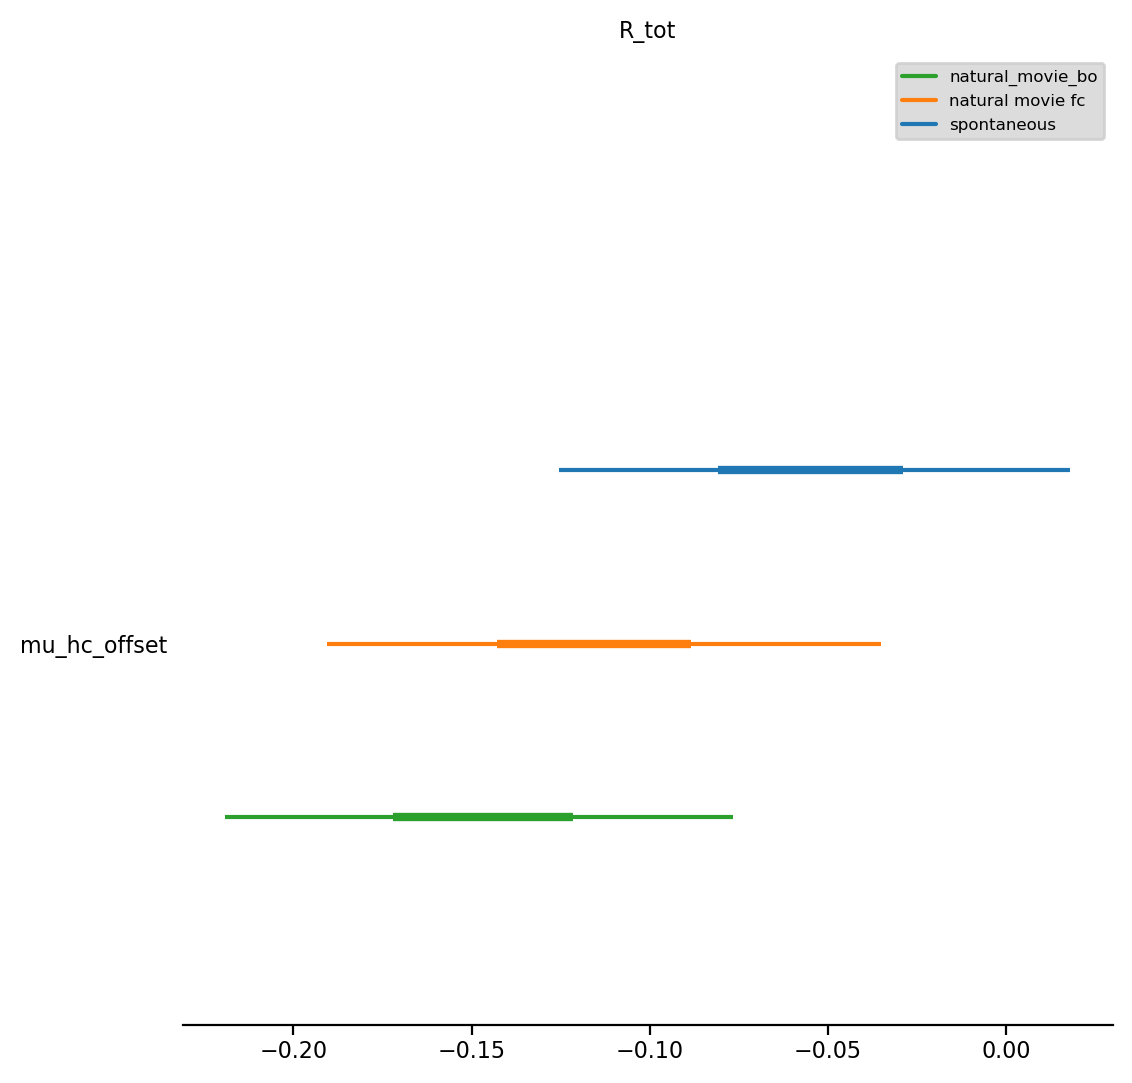

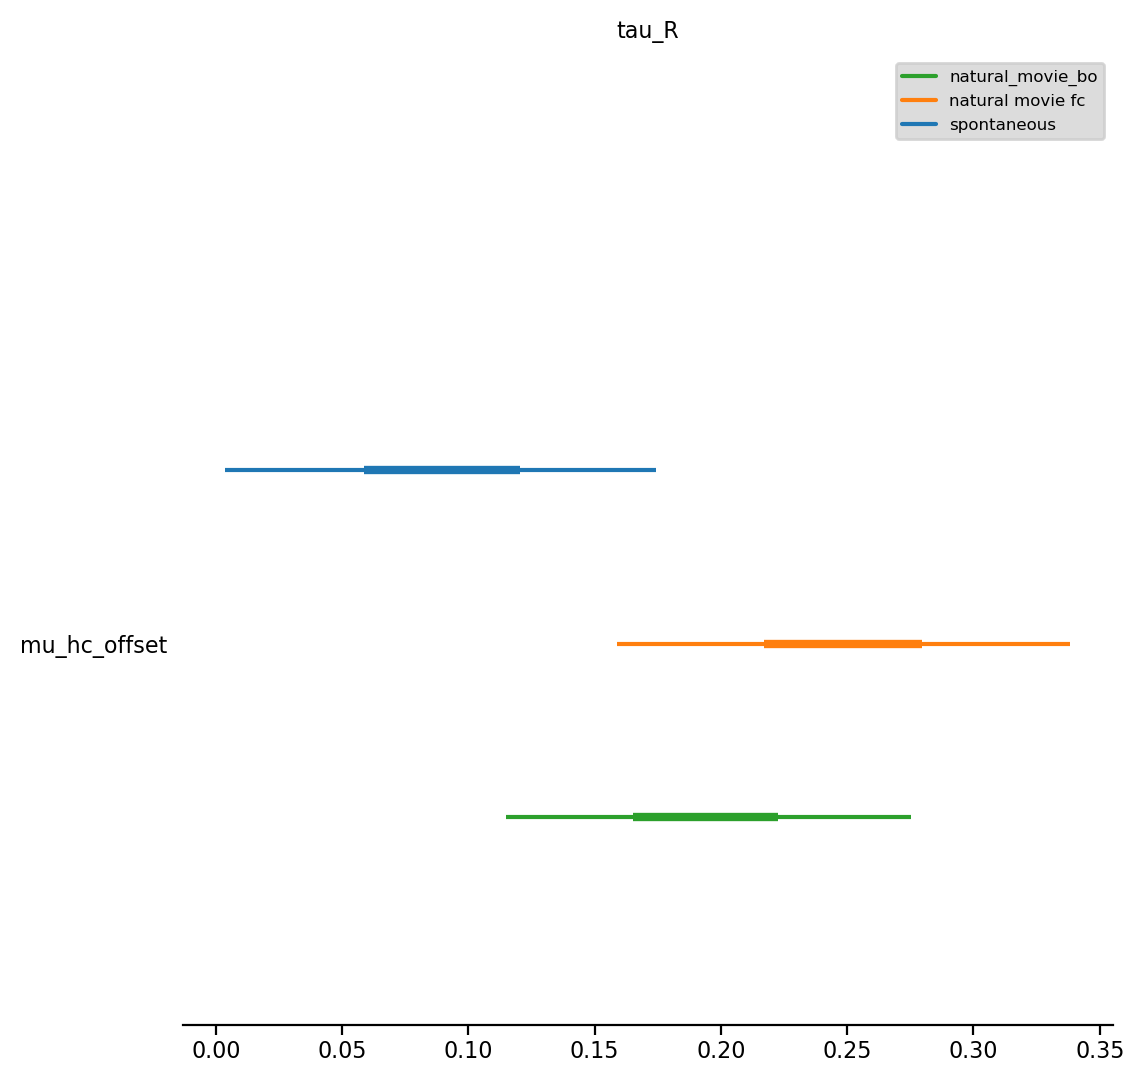

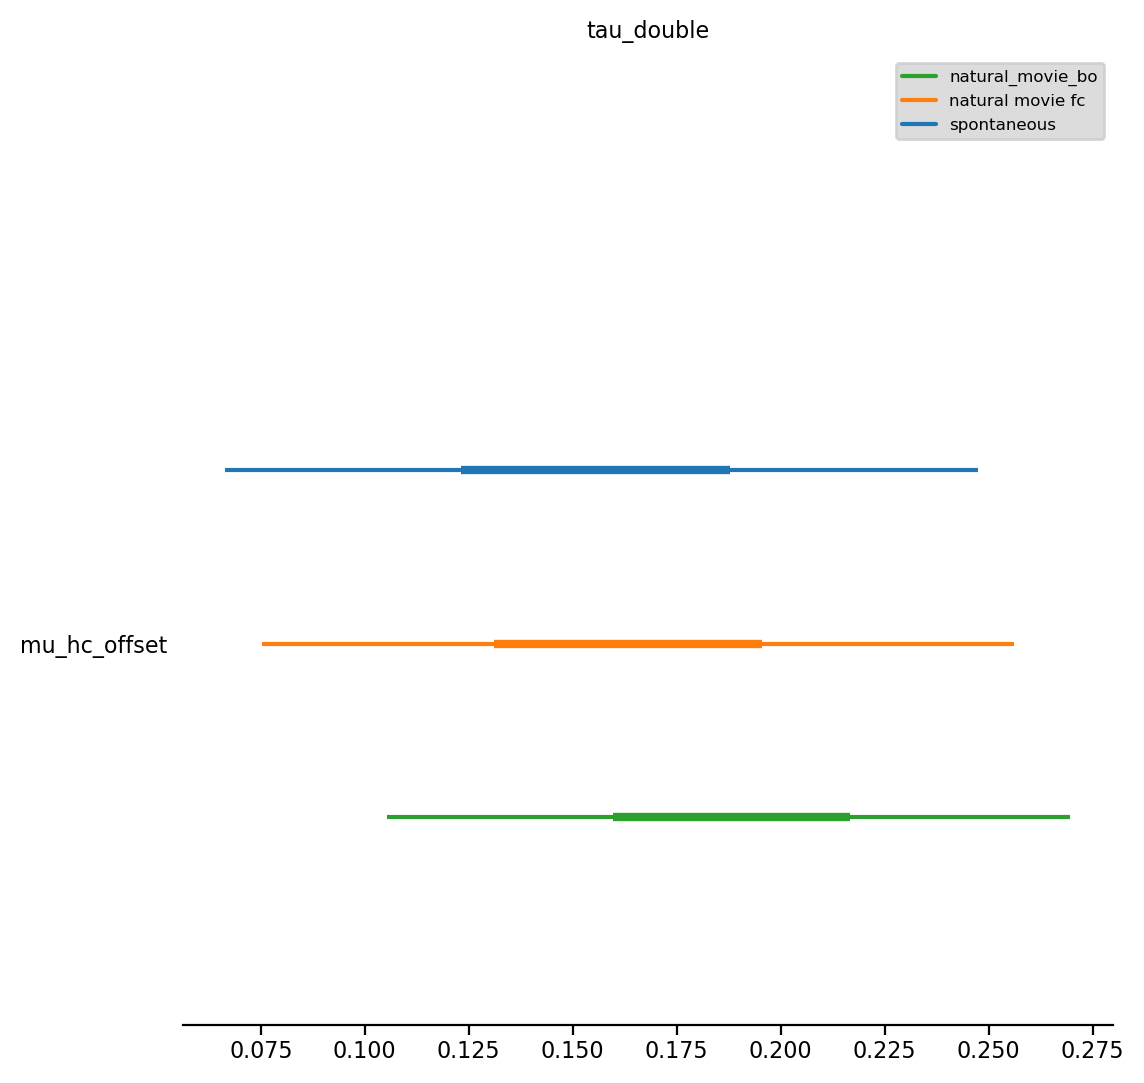

In [12]:
for obs in ["R_tot", "tau_R", "tau_double"]:
    idata_spont = az.from_netcdf(f"{data_dir}/bayes_sgm_{obs}_spontaneous.nc")
    idata_nat_mov_fc = az.from_netcdf(f"{data_dir}/bayes_sgm_{obs}_natural_movie_one_more_repeats.nc")
    idata_nat_mov_bo = az.from_netcdf(f"{data_dir}/bayes_sgm_{obs}_natural_movie_three.nc")
    ax = az.plot_forest(
        [
            idata_spont,
            idata_nat_mov_fc,
            idata_nat_mov_bo,
        ],
        model_names=["spontaneous", "natural movie fc", "natural_movie_bo"],
        var_names=["mu_hc_offset"],
        combined=True, # combines chains
        combine_dims=set(["draw", "session"]),
    )
    ax[0].set_title(obs)

In [12]:
%load_ext watermark
%watermark -v --iversions --packages nutpie,pymc,arviz

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.22.2

nutpie: 0.10.0
pymc  : 5.14.0
arviz : 0.18.0

numpy         : 1.24.4
sys           : 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:34:54) [Clang 16.0.6 ]
pandas        : 2.0.3
arviz         : 0.18.0
IPython       : 8.22.2
nutpie        : 0.10.0
sqlite3       : 2.6.0
logging       : 0.5.1.2
pymc          : 5.14.0
prompt_toolkit: 3.0.42

